<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./32_ltpy_AC_SAF_GOME-2_L3_case_study.ipynb"><< 32 - AC SAF - GOME-2 - Level 3 - Case study </a><span style="float:right;"><a href="./341_ltpy_Ozone_hole_case_study.ipynb">341 - 2019 Antarctic ozone hole case study >></a></span>

# 3.3 Case study - Arctic fires - Summer 2019

Summer 2019 was one of the hottest on record in the Arctic Circle, according to the Copernicus Climate Change service. In June and July there were more than 100 intense and long-lived wildfires in the Arctic Circle.

In late July wildfires raged for days in various regions of the Arctic and Siberia. These fires were unprecedented in duration, extent and emissions. Read more about the Artic fires [here](https://www.eumetsat.int/website/home/Images/ImageLibrary/DAT_4505427.html).

The dynamics and extent of the fires were be monitored by different sensors and data. The following data products are covered:

- [Sentinel-3 OLCI RGB](#sentinel3_olci)
- [CAMS GFAS Wildfire Radiative Power](#cams_gfas)
- [CAMS Total Column Carbon Monoxide](#cams_co)
- [Sentinel-5P Carbon Monoxide](#sentinel_5p)
- [GOME-2 Metop-A/B Aersol Absorbing Index](#gome2_aai)
- [IASI Total Column Carbon Monoxide](#iasi_co)

<hr>

#### Load required libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [3]:
from ipynb.fs.full.ltpy_functions import load_l2_data_xr, generate_masked_array, generate_xr_from_1D_vec, visualize_imshow, visualize_s5p_pcolormesh, visualize_l2, select_channels_for_rgb, normalize, visualize_s3_pcolormesh


<hr>

## <a id='sentinel3_olci'></a>Sentinel-3 OLCI Level 1 RGB

Sentinel-3 OLCI Level 1 RGB composites can highlight areas of smoke resulting from wildfires. Let's go through step by step to load Sentinel-3 OLCI Level 1 data and to build a RGB false color composite.

#### Load OLCI channel information into one xarray object with xarray's function `open_mfdataset`

You can load mulitple file at once with `open_mfdataset`. In the case of Sentinel-3 OLCI Level-1 data, you want to combine the data of all 21 channels into one xarray object. The structure of the single data files is the same, thus you can combine the data by coordinates and you can use the keyword argument `by_coords`.

In [3]:
olci_dir = './eodata/sentinel3/olci/S3A_OL_1_EFR____20190725T023002_20190725T023302_20190726T055350_0179_047_203_1980_LN1_O_NT_002.SEN3/'

In [4]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4090)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa10_radiance  

#### Load the geocoordinates and retrieve the data for `latitude` and `longitude`

You might want to georeference the resulting RGB image. Thus, you can already load the `geo_coordinates.nc` file and retrieve `latitude` and `longitude` information.

In [5]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

#### Select the channels for the RGB composite

The function `select_channels_for_rgb` selects the chosen channels from the loaded xarray object. In this case, we select the channels #17, #05 and #02. Those channels allow to build a false color composite that highlights healthy vegetation in red and also shows the fire smoke more prominently.

In [6]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')


#### Normalize the channels `red`, `green` and `blue`

The function `normalize` normalizes the data values within a range between 0 and 1.

In [7]:
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

#### Stack the RGB channels into a multi-dimensional array with `np.dstack`

In [8]:
rgb = np.dstack((redn, greenn, bluen))

#### Apply a histogram equalization 

A histogram equalization can improve the contrast of the resulting RGB composite. Thus, we use the `exposure` function from the ski-kit-learn library to equalize the image based on the data's histogram.

In [9]:
rgb = exposure.equalize_adapthist(rgb)

#### Map the rgb values onto a color array

If you want to visualize a georeference RGB image, you have to map the rgb values onto a color array with the following code:

In [10]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

#### Visualize the final RGB false color composite with the function `visualize_s3_pcolormesh`

Let's visualize the color array in a georeferenced way with matplotlib's function `pcolormesh`.

/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


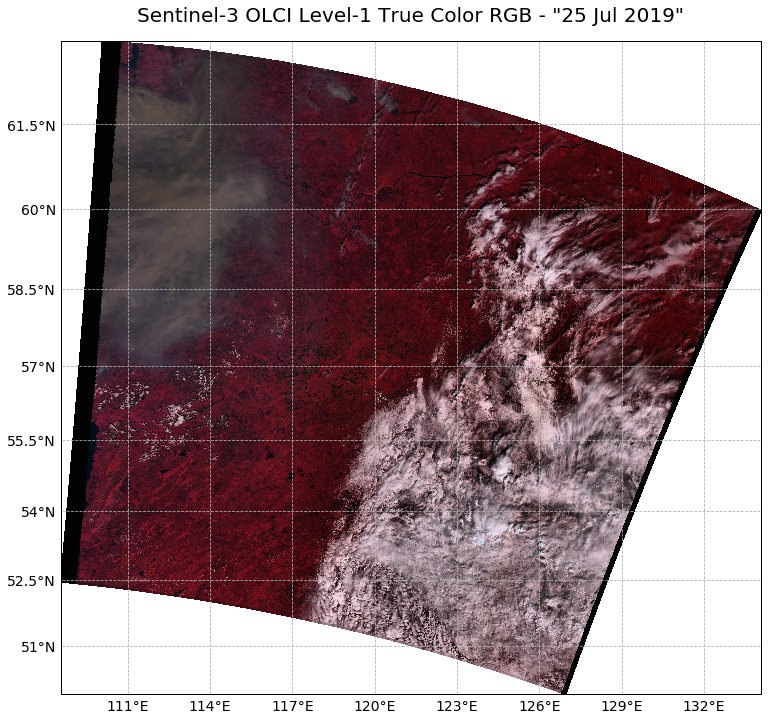

In [11]:
visualize_s3_pcolormesh(colorTuple, red, lat, lon, 'Sentinel-3 OLCI Level-1 True Color RGB - "25 Jul 2019"')

<br>

## <a id='cams_gfas'></a>CAMS GFAS Wildfire Radiative Power

#### Load the data with xarray's `open_dataset`

The dataset contains the `Wildfire radiative power` for 7 days, starting on 23 July 2019. You can extract the `frpfire` variable and also store longname and unit, which will be needed later for visualizing the data.

In [4]:
gfas_frpfire_xr = xr.open_dataset('./eodata/cams/gfas/2019/07/23/20190723_wildfire_radiative_power.nc')
gfas_frpfire_xr

<xarray.Dataset>
Dimensions:    (latitude: 1800, longitude: 3600, time: 7)
Coordinates:
  * longitude  (longitude) float32 -179.95 -179.85 -179.75 ... 179.85 179.95
  * latitude   (latitude) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-29
Data variables:
    frpfire    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-27 16:16:46 GMT by grib_to_netcdf-2.14.1: grib_to_n...

In [7]:
frpfire = gfas_frpfire_xr['frpfire']
longname = frpfire.long_name
unit = frpfire.units
frpfire[1,1,1]

<xarray.DataArray 'frpfire' ()>
array(-4.854537e-07, dtype=float32)
Coordinates:
    longitude  float32 -179.85
    latitude   float32 89.85
    time       datetime64[ns] 2019-07-24
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

#### Subset the data for Eastern Arctic region with `xarray.where` function

The wildfires occured over Siberia and the Arctic. Let's create a geographical subset, to highlight the fire occurrences for this specific region. You can use xarray's function `where` to do so.

In [9]:
latmin=-10
latmax=90
lonmin=40
lonmax=180
frpfire_subset = frpfire.where((frpfire.latitude < latmax) & (frpfire.latitude > latmin) & (frpfire.longitude < lonmax) & (frpfire.longitude > lonmin),drop=True)
frpfire_subset

<xarray.DataArray 'frpfire' (time: 7, latitude: 1000, longitude: 1400)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 40.05 40.15 40.25 ... 179.75 179.85 179.95
  * latitude   (latitude) float32 89.95 89.85 89.75 89.65 ... -9.75 -9.85 -9.95
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-29
Attributes:
    units:      W m**-2
    long_name:  Wildfire radiative power

#### Set negative values to `NaN`

The raw data can contain negative values, which you want to flag.

In [10]:
frpfire_subset.values[frpfire_subset.values<0]=np.nan

#### Visualise the Wildfire radiative power with the `visualize_s5p_pcolormesh`  function

Let's visualize the first day of the data set. You can change the value of time in the function below to visualize the `Wildfire Radiative Power` for subsequent days.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x11f6ae470>)

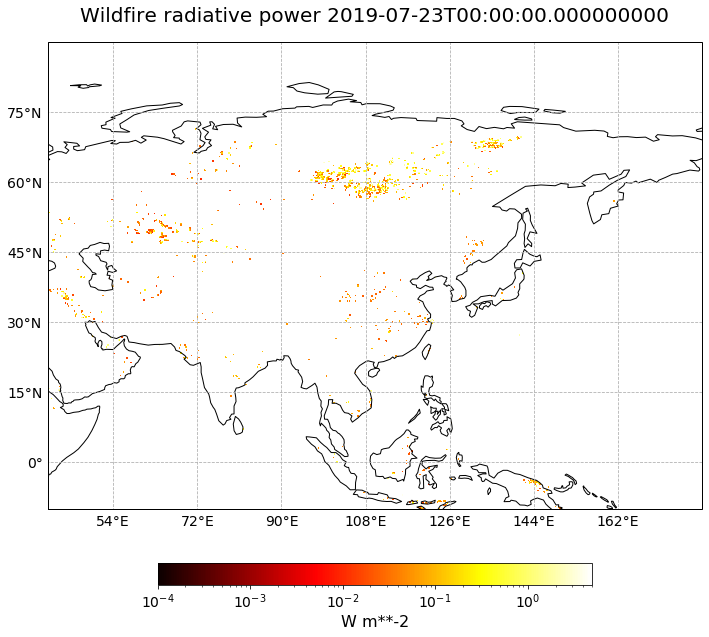

In [11]:
visualize_s5p_pcolormesh(frpfire_subset.isel(time=0).data, frpfire_subset.longitude.data, frpfire_subset.latitude.data, ccrs.PlateCarree(), 'hot', unit, longname + ' ' + str(frpfire_subset.isel(time=0).time.data), 0.0001, 5, lonmin, lonmax, latmin, latmax, log=True, set_global=False)
    

<br>

## <a id='cams_co'></a>CAMS Total column of carbon monoxide

#### Load the data with xarray's function `open_dataset`

You can see that the dataset contains the `Carbon monoxide` values for six days, starting on 23 July 2019. You can extract the `tcco` variable as well as information on title (long name) and unit. These will be required for the visualization at a later stage.

In [14]:
cams_co_tc_xr = xr.open_dataset('./eodata/cams/nrt/co/2019/07/23/20190723_fc_tc_co.nc')
cams_co_tc_xr

<xarray.Dataset>
Dimensions:    (latitude: 901, longitude: 1800, time: 6)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
  * latitude   (latitude) float32 90.0 89.8 89.6 89.4 ... -89.6 -89.8 -90.0
  * time       (time) datetime64[ns] 2019-07-23 2019-07-24 ... 2019-07-28
Data variables:
    tcco       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-27 16:09:08 GMT by grib_to_netcdf-2.14.1: grib_to_n...

In [15]:
tcco = cams_co_tc_xr['tcco']
tcco
longname = tcco.long_name
unit = tcco.units

#### Create a geographic subset for the area where the fires occured

You can create a geographic subset with xarray's function `where`.

In [16]:
latmin=-10
latmax=90
lonmin=40
lonmax=180
tcco_subset = tcco.where((tcco.latitude < latmax) & (tcco.latitude > latmin) & (tcco.longitude < lonmax) & (tcco.longitude > lonmin),drop=True)
tcco_subset

<xarray.DataArray 'tcco' (time: 6, latitude: 499, longitude: 699)>
array([[[0.000695, 0.000695, ..., 0.0007  , 0.0007  ],
        [0.000691, 0.000691, ..., 0.000702, 0.000702],
        ...,
        [0.00059 , 0.000585, ..., 0.000458, 0.000455],
        [0.00059 , 0.000585, ..., 0.000458, 0.000455]],

       [[0.000764, 0.000764, ..., 0.000769, 0.000769],
        [0.000763, 0.000763, ..., 0.000768, 0.000768],
        ...,
        [0.0006  , 0.000598, ..., 0.00048 , 0.000481],
        [0.000602, 0.000601, ..., 0.000479, 0.00048 ]],

       ...,

       [[0.000992, 0.000992, ..., 0.001027, 0.001027],
        [0.000989, 0.000989, ..., 0.00104 , 0.00104 ],
        ...,
        [0.000641, 0.000637, ..., 0.000476, 0.000476],
        [0.000642, 0.000638, ..., 0.000477, 0.000476]],

       [[0.000957, 0.000957, ..., 0.00093 , 0.00093 ],
        [0.000965, 0.000965, ..., 0.000917, 0.000917],
        ...,
        [0.000636, 0.000634, ..., 0.000472, 0.000472],
        [0.000634, 0.000632, ..., 0.0

#### Visualize the Carbon monoxide total column with the function `visualize_s5p_pcolormesh`

Let's visualize the first day (23 July 2019) of the dataset with the help of the function `visualize_s5p_pcolormesh`.

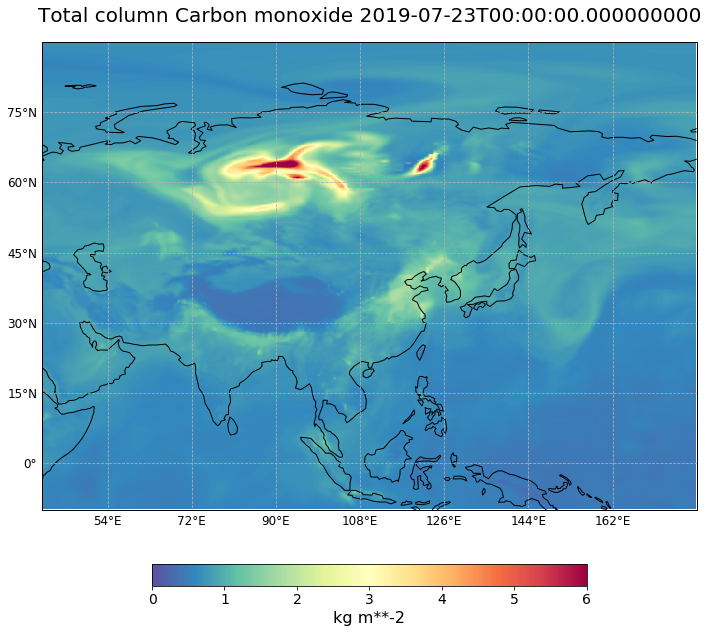

In [63]:
visualize_s5p_pcolormesh(tcco_subset.isel(time=0).data*1000, tcco_subset.longitude.data, tcco_subset.latitude.data, ccrs.PlateCarree(), 'Spectral_r', unit, longname + ' ' + str(tcco_subset.isel(time=0).time.data), 0, 6, lonmin, lonmax, latmin, latmax, log=False, set_global=False)


<br>

## <a id='sentinel_5p'></a> Sentinel-5p Carbon Monoxide

#### Load the data with xarray's `open_mfdataset`

You can load all the datasets available for one day into one xarray object by using `scanline` as concatanation dimension.

In [14]:
s5p_mf = xr.open_mfdataset('./eodata/sentinel5p/co/2019/07/23/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 6490, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * layer                                  (layer) float32 49500.0 ... 500.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * time                                   (time) datetime64[ns] 2019-07-23
  * scanline                               (scanline) float64 0.0 ... 3.244e+03
    latitude                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
    longitude                              (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 3245, 215), meta=np.ndarray>
Data variables:
    delta_time                             (time, scanline) datetime64[ns] dask.array<chunksize=(1, 3245), meta=np.ndarray>
    time_utc                               (time, scanline)

You are interested in the `carbonmonoxide_total_column` variable. You can extract the variable together with geographic coordinates and other information that might be helpful for the plot.

In [34]:
co = s5p_mf.carbonmonoxide_total_column[0,:,:]
lat = co.latitude
lon = co.longitude

unit = co.units
long_name = co.long_name
vmin = 0.01
vmax = 1

latmin=-10
latmax=90
lonmin=40
lonmax=180

#### Visualize the Carbon Monoxide Total Column with the function `visualize_s5p_pcolormesh`

The function takes latitutde and longitude bounds and creates a geographical subset while plotting

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x125fd3860>)

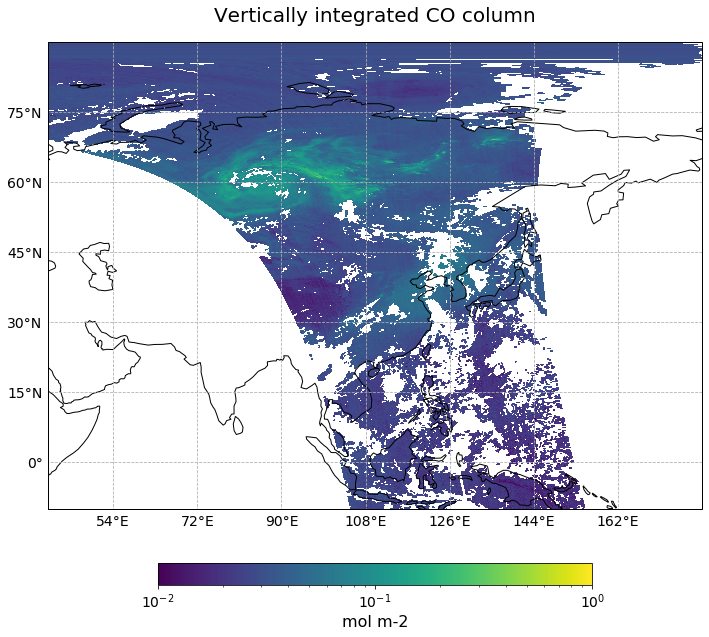

In [38]:
visualize_s5p_pcolormesh(co, lon, lat, ccrs.PlateCarree(), 'viridis', unit, long_name, vmin, vmax, lonmin, lonmax, latmin, latmax, log=True, set_global=False)


<br>

## <a id='gome2_aai'></a>GOME-2 Metop-B Absorbing Aerosol Index (AAI)

#### Load the data with the function `load_l2_data_xr`

Let's load the data file from 23 July 2019 with the function `load_l2_data_xr`.

In [17]:
directory_aai_2b = './eodata/gome2/offline/2b/2019/07/23/'
aai_b_da_mf = load_l2_data_xr(directory_aai_2b, 'DATA', 'AAI','LatitudeCenter','LongitudeCenter',2,'-', 'Absorbing Aerosol Index')
aai_b_da_mf

<xarray.DataArray 'AAI' (ground_pixel: 2142208)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 49.89872 50.22111 ... -66.87211
    longitude     (ground_pixel) float32 14.571395 14.317747 ... 75.10144
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 560 561 562 563 564 565
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

#### Load SunGlintFlag

The `SunGlintFlag` information should be used to flag out not valid entries. You can load the `SunGlintFlag` information as well with the function `load_l2_data_xr`.

In [18]:
sg_b_da_mf = load_l2_data_xr(directory_aai_2b, 'DATA', 'SunGlintFlag','LatitudeCenter','LongitudeCenter',2,'-', 'Sun Glint')
sg_b_da_mf

<xarray.DataArray 'SunGlintFlag' (ground_pixel: 2142208)>
array([-999, -999, -999, ..., -999, -999, -999], dtype=int32)
Coordinates:
    latitude      (ground_pixel) float32 49.89872 50.22111 ... -66.87211
    longitude     (ground_pixel) float32 14.571395 14.317747 ... 75.10144
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 560 561 562 563 564 565
Attributes:
    long_name:  Sun Glint
    units:      -

#### Mask the data array with the `SunGlintFlag` information

The function `generate_masked_array` let's you mask out the non-valid data entries based on the loaded sun glint flag array. The mask removes all entries where the sun glint flag equals 0.

In [19]:
aai_masked = generate_masked_array(aai_b_da_mf, sg_b_da_mf, 0, '=')
aai_masked

<xarray.DataArray (ground_pixel: 836603)>
array([0.728015, 0.948869, 0.273824, ..., 0.104303, 0.214475, 0.798876],
      dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 55.897163 56.20416 ... -58.22515
    longitude     (ground_pixel) float32 9.027729 8.686933 ... 76.44568 76.39429
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 ... 255 255 255 255 255 255
  - y             (ground_pixel) int64 19 20 21 22 23 28 ... 529 531 534 539 540
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

#### Visualize the data in `Orthographic` projection with the function `visualize_l2`

The function allows to change between different projections. The `ccrs.Orthographic` projection is advantageous to highlight some phenomena close to the poles.

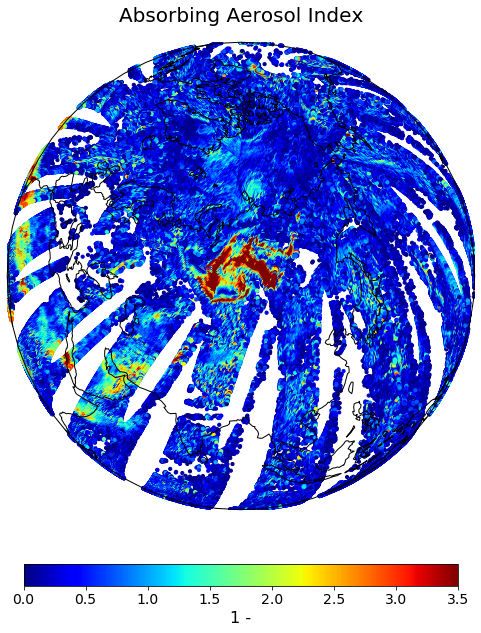

In [21]:
visualize_l2(aai_masked,1,ccrs.Orthographic(90,60),0,3.5,10,'jet', aai_masked.units, aai_masked.long_name, False)

<br>

## <a id='iasi_co'></a>IASI Total Column Carbon Monoxide

#### Load the data file with `pandas`

IASI Total Column Carbon Monoxide data are disseminated in `.txt` format. You can easily load the .txt file with `pandas`, using and empty string and seperator.

Pandas' function `.head()` shows you the first entries of the loaded file.

In [23]:
iasi_file = './eodata/iasi/txt/co/2b/2019/07/iasi_CO_LATMOS_ULB_metopb_20190723_v20151001.txt'


In [24]:
iasi_co = pd.read_csv(iasi_file, sep=" ", header = None)
iasi_co.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-5.28564,-46.54831,20190723,258,131.61,0,1,0,0,0,...,1.967916,1.981760,1.927175,1.811883,1.661120,1.486958,1.294062,1.093281,0.894955,-0.061292
1,-5.03226,-46.60137,20190723,258,131.46,1,1,0,0,0,...,1.892960,1.873258,1.791627,1.660121,1.500409,1.325970,1.138707,0.948803,0.766456,-0.042892
2,-5.13056,-47.08466,20190723,258,131.06,2,1,0,0,1,...,2.180583,2.258604,2.246180,2.152696,2.011326,1.838382,1.635759,1.414180,1.182802,-0.108790
3,-5.02433,-45.42467,20190723,258,132.54,0,1,0,0,0,...,2.064783,2.093467,2.059924,1.965963,1.823733,1.650130,1.454150,1.245359,1.032613,-0.111512
4,-4.79073,-45.47406,20190723,258,132.41,1,1,0,0,0,...,1.991248,1.993741,1.934715,1.820194,1.668977,1.496648,1.306471,1.108603,0.910080,-0.080651


#### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function `generate_xr_from_1D_vec` to load the `Total Column Carbon Monoxide` information into a xarray.

The data holds as well a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information as well into a xarray.

In [26]:
iasi_co_da = generate_xr_from_1D_vec(iasi_co,0, 1, iasi_co[20], 'co', 'IASI Carbon Monoxide Total Column', 1, 'molec./cm-2')

In [27]:
iasi_co_qf_da = generate_xr_from_1D_vec(iasi_co,0, 1, iasi_co[15], 'qf', 'Super Quality Flag', 1, '-')

#### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function `generate_masked_array` allows you to flag out the quality flags. If the quality flag is 0, the data values are flagged.

In [29]:
iasi_co_masked = generate_masked_array(iasi_co_da,iasi_co_qf_da,0,'=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 413517)>
array([1.860367e+18, 1.897558e+18, 2.009047e+18, ..., 1.471667e+18,
       1.455511e+18, 1.435054e+18])
Coordinates:
    latitude   (ground_pixel) float64 -5.286 -5.032 -5.024 ... 71.52 71.47 71.26
    longitude  (ground_pixel) float64 -46.55 -46.6 -45.42 ... -45.23 -45.12
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

#### Visualize the maked dataset with the function `visualize_l2`

You can visualize the IASI Total Column Carbon Monoxide data again with an `Orthographic` project and focus on the region over Siberia.

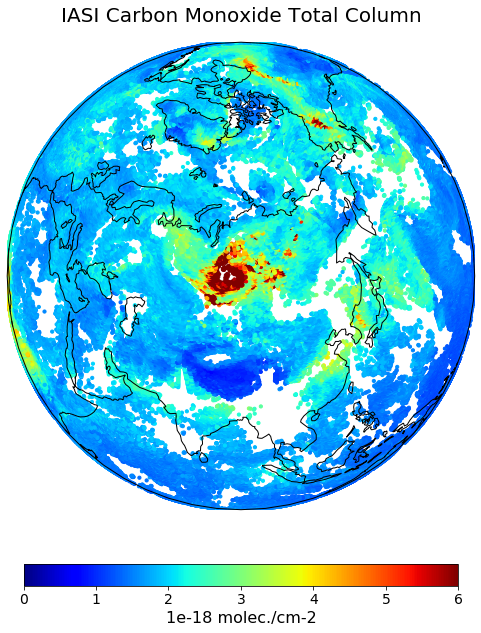

In [33]:
visualize_l2(iasi_co_masked, 1e-18,ccrs.Orthographic(90,60), 0, 6, 10, 'jet', iasi_co_masked.units, iasi_co_masked.long_name,  )

<br>

Let's also visualize the same example, but in a PlateCarree() projection.

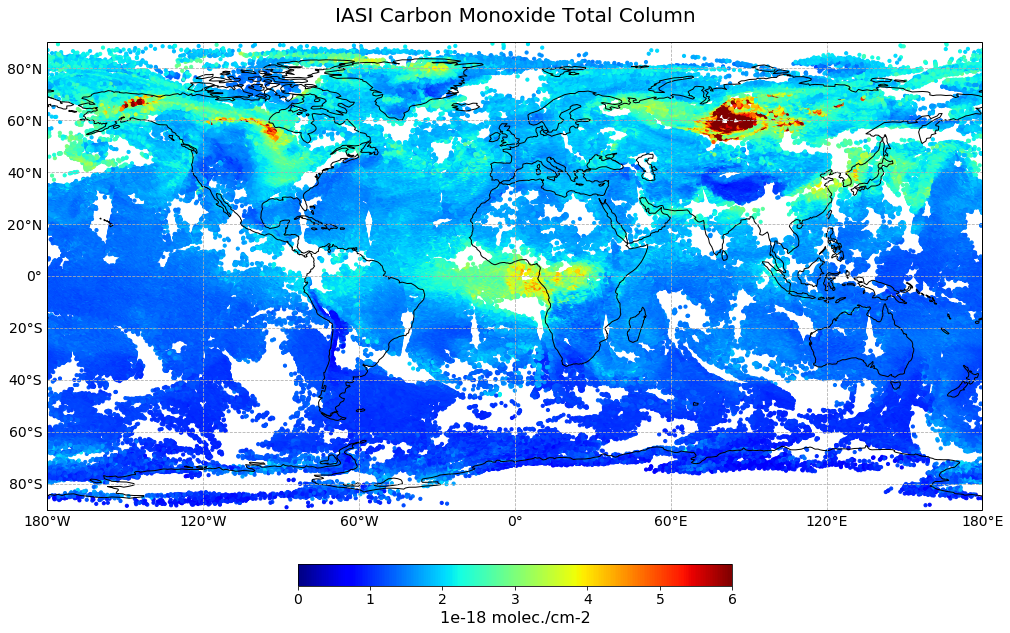

In [35]:
visualize_l2(iasi_co_masked, 1e-18,ccrs.PlateCarree(), 0, 6, 10, 'jet', iasi_co_masked.units, iasi_co_masked.long_name)

<br>

<a href="./32_ltpy_AC_SAF_GOME-2_L3_case_study.ipynb"><< 32 - AC SAF - GOME-2 - Level 3 - Case study </a><span style="float:right;"><a href="./341_ltpy_Ozone_hole_case_study.ipynb">341 - 2019 Antarctic ozone hole case study >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>